ENSTA - Filtrage bayésen et approximation particulaire
===

## TP1: Recalage altimétrique de navigation inertielle

### Jean Baptiste Soubaras et Pierre Cortambert

Un avion survole une zone dont le relief est connu: la hauteur $h(r)$ du relief en chaque point de coordonnée horizontale $r$ est connue, et enregistrée dans une carte numérique fournie dans le fichier $mnt.mat$.

In [29]:
%matplotlib inline

import numpy as np # calcul numerique
import numpy.random as rnd # fonctions pseudo-aleatoires
import matplotlib.pyplot as plt # fonctions graphiques a la MATLAB
import matplotlib.animation as anim # fonctions d’animation
import scipy.io as io # fonctions pour l’ouverture des fichiers .mat de MATLAB
import math as m

from matplotlib import animation
from IPython.core.display import HTML

In [30]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [31]:
X1MIN = -10000
X1MAX = 10000
X2MIN = -10000
X2MAX = 10000
r0 = (-6000, 2000)
v0 = (120, 0)
sigma_r0 = 100
sigma_v0 = 10
sigma_ins = 7
sigma_alt = 10
sigma_bar = 20
delta = 1
T = 100 

## 1 - Représentation de la position horizontale exacte $r_k$ de l'avion pour chaque instant entre 0 et T.




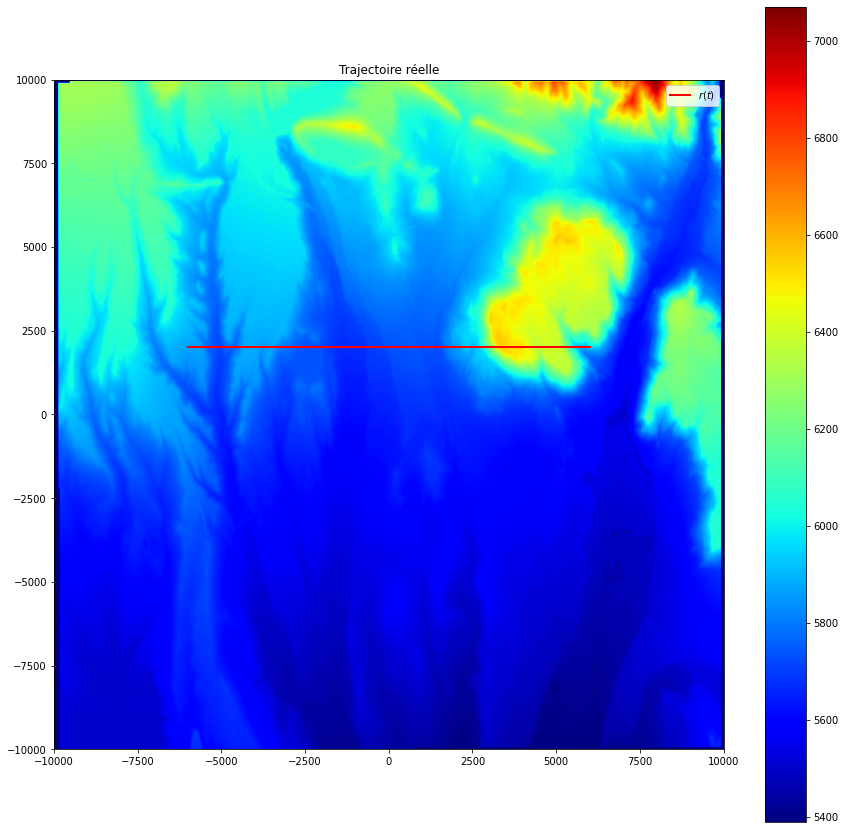

In [32]:
map = io.loadmat('mnt.mat')['map']
N1 = map.shape[0]
N2 = map.shape[1]

traj = io.loadmat('traj.mat')
rtrue = traj['rtrue']
vtrue = traj['vtrue']

plt.figure(figsize=(15,15))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt.plot(rtrue[0,:],rtrue[1,:],'r-', label=r'$r(t)$', linewidth=2)
plt.colorbar()
plt.title("Trajectoire réelle")
plt.legend()
plt.show()

## 2 - Représentation de la position horizontale exacte $r_k$ de l'avion pour chaque instant entre 0 et T ainsi que de son estimation inertielle $r_k^{INS}$.

Nous remarquons que la trajectoire estimée ne correspond pas à la réelle trajectoire de l'avion. La position de l'avion est bien initialisée mais dévie avec le temps.




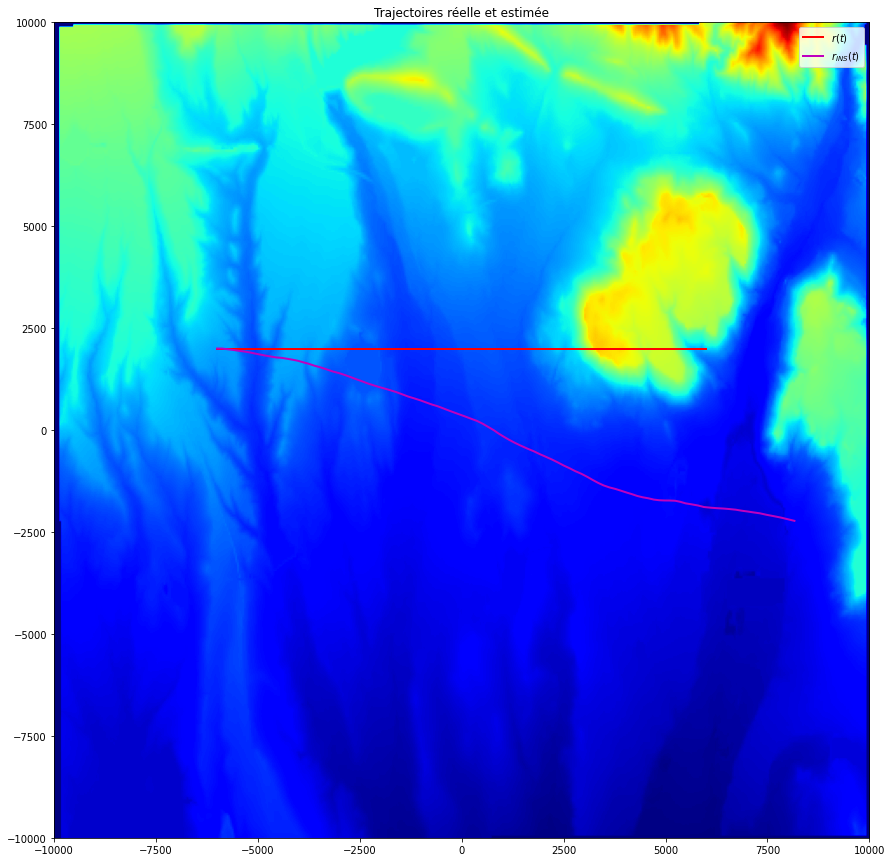

In [33]:
a_INS = io.loadmat('ins.mat')['a_INS']

r_INS = np.zeros(rtrue.shape)
v_INS = np.zeros(vtrue.shape)
r_INS[:,0] = r0
v_INS[:,0] = v0

nmax = len(rtrue[0,:])

for k in range(1,nmax):
    r_INS[:,k] = r_INS[:,k-1]+delta*v_INS[:,k-1]
    v_INS[:,k] = v_INS[:,k-1]+delta*a_INS[:,k-1]
    
plt.figure(figsize=(15,15))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt.plot(rtrue[0,:],rtrue[1,:],'r-', label=r'$r(t)$', linewidth=2)
plt.plot(r_INS[0,:],r_INS[1,:],'m-', label=r'$r_{INS}(t)$', linewidth=2)
plt.legend()
plt.title("Trajectoires réelle et estimée")
plt.show()

## 3 - Explicitation du modèle d'état.

On introduit comme nouvelles variables d'état les erreurs d'estimation inertielle $\delta r_{k}=$ $r_{k}-r_{k}^{\mathrm{INS}}$ sur la position horizontale et $\delta v_{k}=v_{k}-v_{k}^{\mathrm{INS}}$ sur la vitesse horizontale. 

On a :

$$\left(\begin{array}{c}
r_{k}^{\mathrm{INS}} \\
v_{k}^{\mathrm{INS}}
\end{array}\right)=\left(\begin{array}{cc}
I_{2} & \Delta I_{2} \\
0 & I_{2}
\end{array}\right)\left(\begin{array}{c}
r_{k-1}^{\mathrm{INS}} \\
v_{k-1}^{\mathrm{INS}}
\end{array}\right)+\Delta\left(\begin{array}{c}
0 \\
a_{k}^{\mathrm{INS}}
\end{array}\right) \quad \text { avec } \quad\left(\begin{array}{c}
r_{0}^{\mathrm{INS}} \\
v_{0}^{\mathrm{INS}}
\end{array}\right)=\left(\begin{array}{c}
r_{0} \\
v_{0}
\end{array}\right) \quad (1)$$

et

$$\left(\begin{array}{c}
r_{k} \\
v_{k}
\end{array}\right)=\left(\begin{array}{cc}
I_{2} & \Delta I_{2} \\
0 & I_{2}
\end{array}\right)\left(\begin{array}{c}
r_{k-1} \\
v_{k-1}
\end{array}\right)+\Delta\left(\begin{array}{c}
0 \\
a_{k}
\end{array}\right) \quad \quad (2)$$

---

En effectuant $(2)-(1)$, on obtient :

$$\left(\begin{array}{c}
\delta r_{k} \\
\delta v_{k}
\end{array}\right)=\left(\begin{array}{cc}
I_{2} & \Delta I_{2} \\
0 & I_{2}
\end{array}\right)\left(\begin{array}{c}
\delta r_{k-1} \\
\delta v_{k-1}
\end{array}\right)-\Delta\left(\begin{array}{c}
0 \\
w_{k}^{\mathrm{INS}}
\end{array}\right) \quad \text { avec } \quad\left(\begin{array}{c}
\delta r_{0} \\
\delta v_{0}
\end{array}\right)=\left(\begin{array}{l}
0 \\
0
\end{array}\right)$$

## 4 et 5 - Représentation du profil exact et bruité du relief survolé dans un plan vertical à chaque instant entre 0 et T.

A chaque instant $t_{k}$, on lit sur la carte la hauteur $h\left(r_{k}\right)$ du relief au point de coordonnée horizontale $r_{k}$ situé à la verticale de l'avion. 

La hauteur du relief survolé à l'instant $t_k$ déduite à partir des mesures fournies par le radio-altimètre et par le baromètre est : $h_{k}^{\mathrm{ALT}} = z_{k}^{\mathrm{BAR}} - d_{k}^{\mathrm{ALT}}  =h\left(r_{k}\right)+w_{k}^{\mathrm{BAR}}-w_{k}^{\mathrm{ALT}}$

Or puisque $r_k = r_k^{\mathrm{INS}} + \delta_k$, alors :  $h_{k}^{\mathrm{ALT}}=h\left(r_{k}^{\mathrm{INS}}+\delta r_{k}\right)+w_{k}^{\mathrm{BAR}}-w_{k}^{\mathrm{ALT}}$


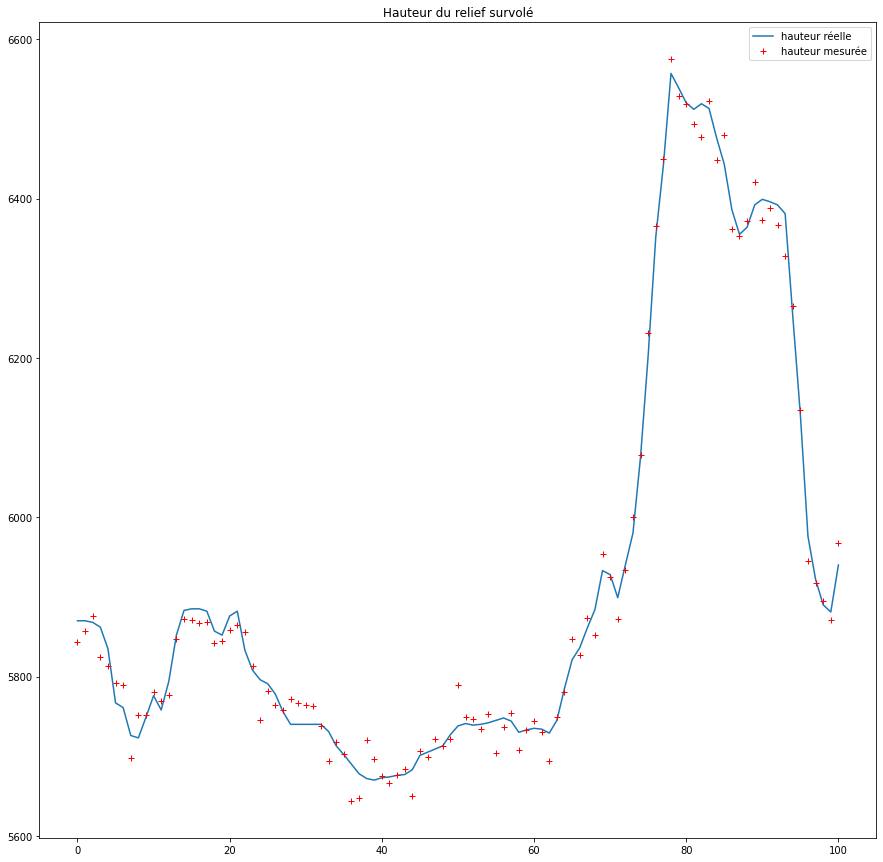

In [34]:
def real_height(x1, x2):
    i = int((X1MAX-x1)*N1/(X1MAX-X1MIN))
    j = int((x2-X2MIN)*N2/(X2MAX-X2MIN))
    return map[np.clip(i, 0, N1-1), np.clip(j,0,N2-1)]

h = []
for i in range(nmax) :
    h.append(real_height(rtrue[1,i], rtrue[0,i]))
    
h_ALT = io.loadmat('alt.mat')['h_ALT'][0]

plt.figure(figsize=(15,15))
plt.plot(h, label='hauteur réelle')
plt.plot(h_ALT, 'r+', label='hauteur mesurée')
plt.title("Hauteur du relief survolé")
plt.legend()
plt.show()

## 6 - Expression de la fonction de vraisemblance.
$g_k(x) = q_k^V (Y_k - h_k(x))$

$g_{k}(r_k) = q_{k}^{V}(h_{k}^{\mathrm{ALT}}-h(r_k))$

$g_{k}(r_k) = q_{k}^{V}(h(r_{k}^{\mathrm{INS}}+\delta r_{k})+w_{k}^{\mathrm{BAR}}-w_{k}^{\mathrm{ALT}}-h(r_k))$

$\sigma^2 \equiv \sigma_{BAR}^2 + \sigma_{ALT}^2\\
g_k \sim N(0, \sigma^2)$

$$g_k(r) = \frac{1}{\sigma\sqrt{2\pi}} exp\left(-\frac{1}{2}\left(\frac{h_k^{\mathrm{ALT}} -h(r)}{\sigma}\right)^2\right)$$

fonction Python 
Permet de simuler rapidement un échantillon distribué selon une loi discrète donnée, et qui sera utilisée dans ce TP pour réaliser la redistribution multinomiale.


In [35]:
#implementation fonction de vraissemblance
def g(k,dr):
  #print(np.exp(-0.5*(h_ALT[k]-real_height(r_INS[0,k] +dr[0],r_INS[1,k] + dr[1]))**2/(sigma_alt**2+sigma_bar**2)))
  return (1/np.sqrt(2*np.pi*(sigma_alt**2 + sigma_bar**2)))*np.exp(-0.5*((h_ALT[k]-real_height(r_INS[1,k] +dr[1], r_INS[0,k] + dr[0]))**2)/(sigma_alt**2 + sigma_bar**2))

#condition initiale incertaine
def eta_0():
    return rnd.normal(scale=[sigma_r0,sigma_r0,sigma_v0,sigma_v0])

#équation d'état
def Q(state):
    mat=np.eye(4)+np.diagflat([delta,delta],2)
    w = np.array([0,0,rnd.normal(0,sigma_ins),rnd.normal(0,sigma_ins)])
    return np.matmul(mat,state) - delta*w

# definition d'une fonction donnant les indices des ancetres dans la redistribution multinomiale
def resampling_multi(w,N):
    u_tild = np.zeros((N))
    expo = np.zeros((N))
    alpha = np.zeros((N))
    u_ord = np.zeros((N))
    u = np.zeros((N+1))
    s = np.zeros((N))
    w = w/w.sum()
    s = np.cumsum(w)
    u_tild = rnd.uniform(0,1,N)
    for i in range(N):
        alpha[i] = u_tild[i]**(1/float(i+1)) #u_tild : uniformes
    alpha = np.cumprod(alpha) #alpha : meme distribution que des alphas triees
    u_ord = alpha[N-1]/alpha 
    u = np.append(u_ord,float("inf"))
    ancestor = np.zeros(N,dtype=int)
    offsprings = np.zeros(N,dtype=int)
    i = 0
    for j in range(N):
        o = 0
        while u[i]<=s[j]:
            ancestor[i] = j
            i = i+1
            o = o+1
        offsprings[j] = o
    return ancestor

## 7 - Filtre particulaire SIR

In [36]:
#Algo SIR : required (distribution de proba eta_0(dx) c'est un dirac ici, proba de transition Q_k(x,dx'), fonction de selection g_k(x') correspondant à la fonction de vraissemblance)
def SIR(eta_0,Q,g,N,T):
    ksi = np.zeros((T,N,4))
    w = np.zeros((T,N))

    ksi[0,:] = [eta_0() for i in range(N)]
    w[0,:] = [g(0,ksi[0,i]) for i in range(N)]
    w[0] /= np.sum(w[0])
        
    for k in range(1,T):
        R = resampling_multi(w[k-1,:],N) #fournit les indices des particules sélectionnées de poids respectifs W[k-1]
        ksi_chapeau = [ksi[k-1,n] for n in R] # on selectionne un individu au sein de la population precedement définie

        ksi[k,:] = [Q(ksi_chapeau[i]) for i in range(N)]
        w[k,:] = [g(k,ksi[k,i]) for i in range(N)]
        w[k] /= np.sum(w[k])
        
    return ksi,w

In [ ]:
N = 1000

delta_r,w = SIR(eta_0, Q, g, N, T)
r_part = np.zeros((2,N,T))
means = np.zeros((2,T))

for k in range(T):
    for i in range(N):
        r_part[:,i,k] = r_INS[:,k] + delta_r[k,i,:2] 
        means[:,k] += w[k,i]*r_part[:,i,k] 

fig = plt.figure(figsize=(15,15))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt1, = plt.plot([],[],'+',c='white')
plt.plot([],[],'+',c='white', label='particules')
plt.plot(rtrue[0],rtrue[1],'r-', label='trajectoire réelle')
plt.plot(r_INS[0],r_INS[1],'m-', label='estimation inertielle')
plt.plot(rtrue[0,0], rtrue[1,0], 'o', c='black', label=r'$r_0$')
plt2, = plt.plot([],[], lw=2.5, c='g', label='moyenne pondérées des particules')
plt.xlim(X1MIN,X1MAX)
plt.ylim(X2MIN,X2MAX)
plt.title("Trajectoire estimée par filtrage SIR (N=1000)")
plt.legend(loc='lower left')

In [38]:
def drawframe(k):
    plt1.set_data(r_part[0,:,:k],r_part[1,:,:k])
    plt2.set_data(means[0,:k], means[1,:k])
    
    return (plt1, plt2)

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=20, blit=True)

HTML(anim.to_html5_video())

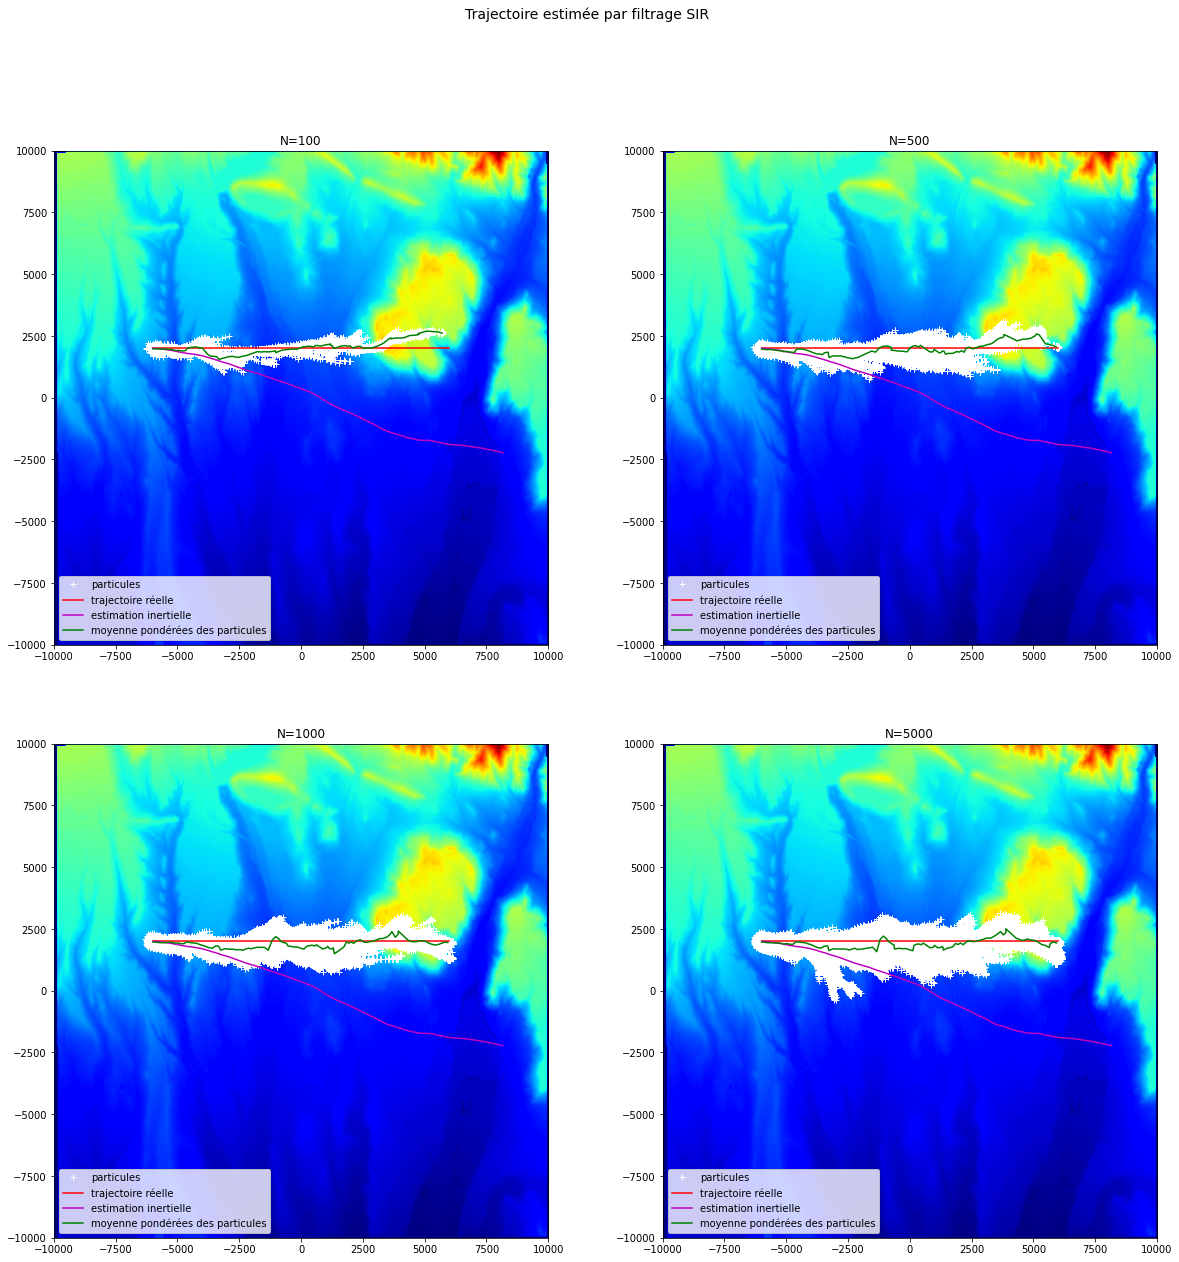

In [39]:
N = [100, 500, 1000, 5000]

plt.figure(figsize=(20,20))
plt.suptitle("Trajectoire estimée par filtrage SIR", fontsize=14)

for idx in range(4):

    delta_r,w = SIR(eta_0, Q, g, N[idx], T)
    r_part = np.zeros((2,N[idx],T))
    means = np.zeros((2,T))

    for k in range(T):
        for i in range(N[idx]):
            r_part[:,i,k] = r_INS[:,k] + delta_r[k,i,:2] 
            means[:,k] += w[k,i]*r_part[:,i,k] 


    plt.subplot(2,2,idx+1)
    plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
    plt.plot(r_part[0,:],r_part[1,:],'+',c='white')
    plt.plot([],[],'+',c='white', label='particules')
    plt.plot(rtrue[0,:],rtrue[1,:],'r-', label='trajectoire réelle')
    plt.plot(r_INS[0,:],r_INS[1,:],'m-', label='estimation inertielle')
    plt.plot(means[0,:], means[1,:], 'green', label='moyenne pondérées des particules')
    plt.xlim(X1MIN,X1MAX)
    plt.ylim(X2MIN,X2MAX)
    plt.title(f"N={N[idx]}")
    plt.legend(loc='lower left')

## 8 - Filtre particulaire SIS (sans redistribution adaptative)

In [40]:
def SIS(eta_0,Q,g,N,T):
    ksi = np.zeros((T,N,4))
    w = np.zeros((T,N))

    ksi[0,:] = [eta_0() for i in range(N)]
    w[0,:] = [g(0,ksi[0,i]) for i in range(N)]
    w[0] /= np.sum(w[0])

    for k in range(1,T):
        ksi[k,:] = [Q(ksi[k-1,i]) for i in range(N)]
        w[k,:] = [w[k-1,i]*g(k,ksi[k,i]) for i in range(N)]
        w[k] /= np.sum(w[k])

    return ksi, w

In [ ]:
N = 1000

delta_r,w = SIS(eta_0, Q, g, N, T)
r_part = np.zeros((2,N,T))
means = np.zeros((2,T))

for k in range(T):
    for i in range(N):
        r_part[:,i,k] = r_INS[:,k] + delta_r[k,i,:2] 
        means[:,k] += w[k,i]*r_part[:,i,k] 

fig = plt.figure(figsize=(15,15))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt1, = plt.plot([],[],'+',c='white')
plt.plot([],[],'+',c='white', label='particules')
plt.plot(rtrue[0],rtrue[1],'r-', label='trajectoire réelle')
plt.plot(r_INS[0],r_INS[1],'m-', label='estimation inertielle')
plt.plot(rtrue[0,0], rtrue[1,0], 'o', c='black', label=r'$r_0$')
plt2, = plt.plot([],[], lw=2.5, c='g', label='moyenne pondérées des particules')
plt.xlim(X1MIN,X1MAX)
plt.ylim(X2MIN,X2MAX)
plt.title("Trajectoire estimée par filtrage SIS (N=1000)")
plt.legend(loc='lower left')

In [49]:
anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=20, blit=True)

HTML(anim.to_html5_video())

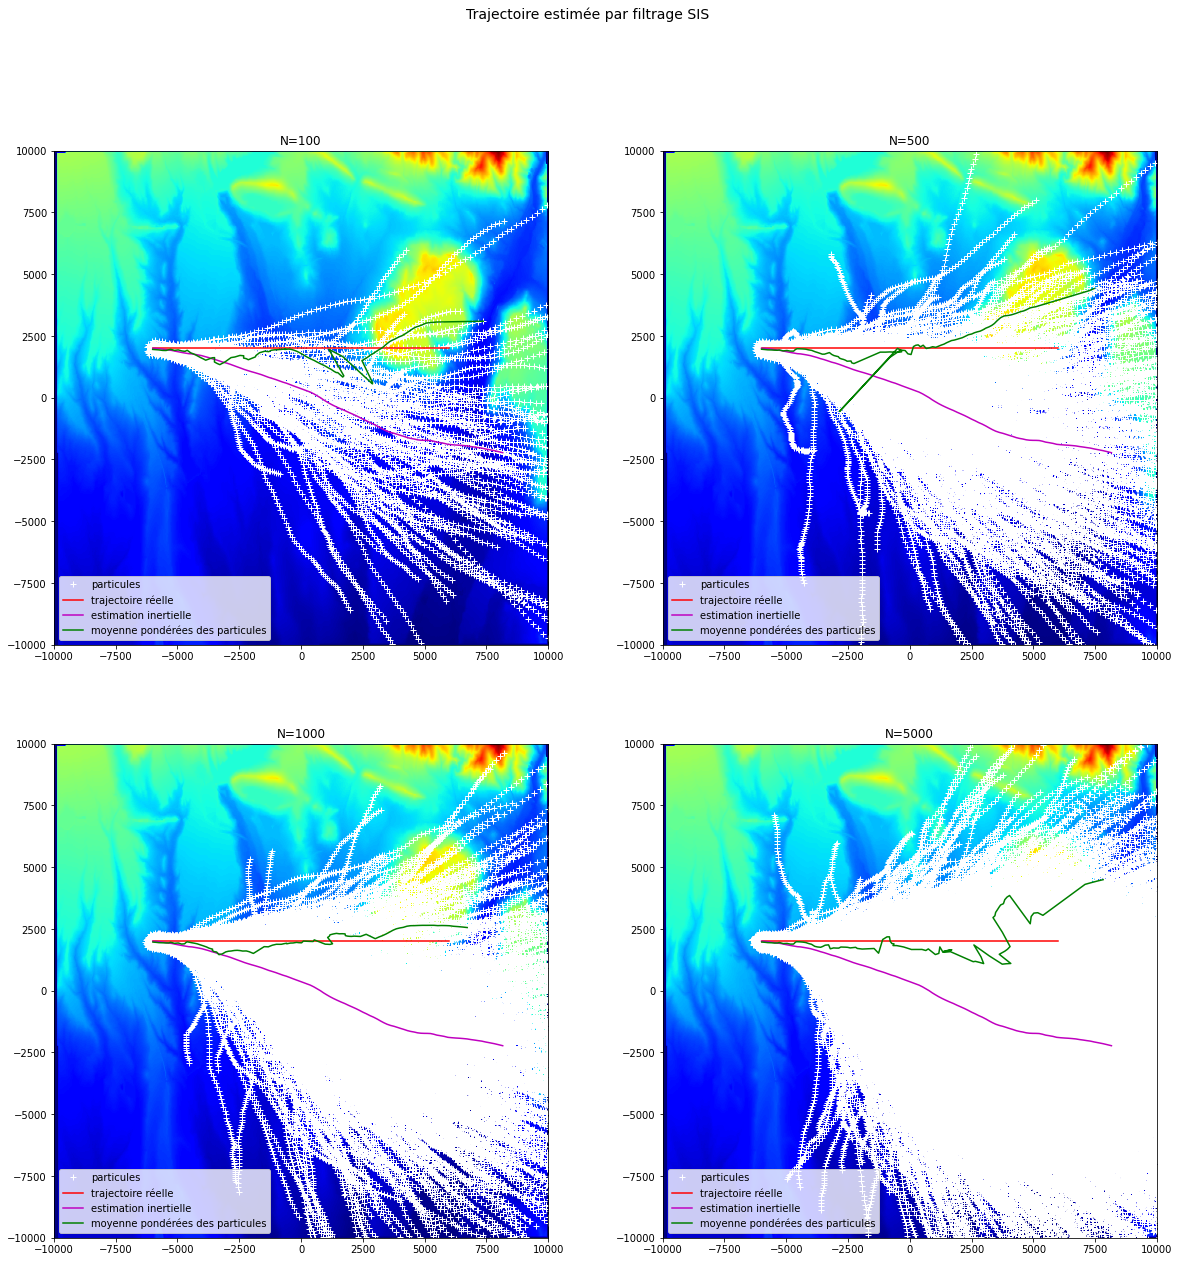

In [43]:
N = [100, 500, 1000, 5000]

plt.figure(figsize=(20,20))
plt.suptitle("Trajectoire estimée par filtrage SIS", fontsize=14)

for idx in range(4):

    delta_r,w = SIS(eta_0, Q, g, N[idx], T)
    r_part = np.zeros((2,N[idx],T))
    means = np.zeros((2,T))

    for k in range(T):
        for i in range(N[idx]):
            r_part[:,i,k] = r_INS[:,k] + delta_r[k,i,:2] 
            means[:,k] += w[k,i]*r_part[:,i,k] 


    plt.subplot(2,2,idx+1)
    plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
    plt.plot(r_part[0,:],r_part[1,:],'+',c='white')
    plt.plot([],[],'+',c='white', label='particules')
    plt.plot(rtrue[0,:],rtrue[1,:],'r-', label='trajectoire réelle')
    plt.plot(r_INS[0,:],r_INS[1,:],'m-', label='estimation inertielle')
    plt.plot(means[0,:], means[1,:], 'green', label='moyenne pondérées des particules')
    plt.xlim(X1MIN,X1MAX)
    plt.ylim(X2MIN,X2MAX)
    plt.title(f"N={N[idx]}")
    plt.legend(loc='lower left')

## 9 - Filtre particulaire avec redistribution adaptative

In [44]:
def adaptative_filter(eta_0,Q,g,N,T,c):
    ksi = np.zeros((T,N,4))
    w = np.zeros((T,N))

    ksi[0,:] = [eta_0() for i in range(N)]
    w[0,:] = [g(0,ksi[0,i]) for i in range(N)]
    w[0] /= np.sum(w[0])
        
    for k in range(1,T):
        Neff = 1/(sum(w[k-1,i]**2 for i in range(N)))

        if Neff <= c*N : # Algorithme SIR

            R = resampling_multi(w[k-1,:],N) #fournit les indices des particules sélectionnées de poids respectifs W[k-1]
            ksi_chapeau = [ksi[k-1,n] for n in R] # on selectionne un individu au sein de la population precedement définie

            ksi[k,:] = [Q(ksi_chapeau[i]) for i in range(N)]
            w[k,:] = [g(k,ksi[k,i]) for i in range(N)]

        else : #Algorithme SIS

            ksi[k,:] = [Q(ksi[k-1,i]) for i in range(N)]
            w[k,:] = [w[k-1,i]*g(k,ksi[k,i]) for i in range(N)]
        
        w[k] /= np.sum(w[k])
        
    return ksi,w

In [ ]:
N = 1000
c = 0.6

delta_r,w = adaptative_filter(eta_0, Q, g, N, T, c)
r_part = np.zeros((2,N,T))
means = np.zeros((2,T))

for k in range(T):
    for i in range(N):
        r_part[:,i,k] = r_INS[:,k] + delta_r[k,i,:2] 
        means[:,k] += w[k,i]*r_part[:,i,k] 

fig = plt.figure(figsize=(15,15))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt1, = plt.plot([],[],'+',c='white')
plt.plot([],[],'+',c='white', label='particules')
plt.plot(rtrue[0],rtrue[1],'r-', label='trajectoire réelle')
plt.plot(r_INS[0],r_INS[1],'m-', label='estimation inertielle')
plt.plot(rtrue[0,0], rtrue[1,0], 'o', c='black', label=r'$r_0$')
plt2, = plt.plot([],[], lw=2.5, c='g', label='moyenne pondérées des particules')
plt.xlim(X1MIN,X1MAX)
plt.ylim(X2MIN,X2MAX)
plt.title("Trajectoire estimée par filtrage adaptatif (N=1000, c=0.6)")
plt.legend(loc='lower left')

In [51]:
anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=20, blit=True)

HTML(anim.to_html5_video())

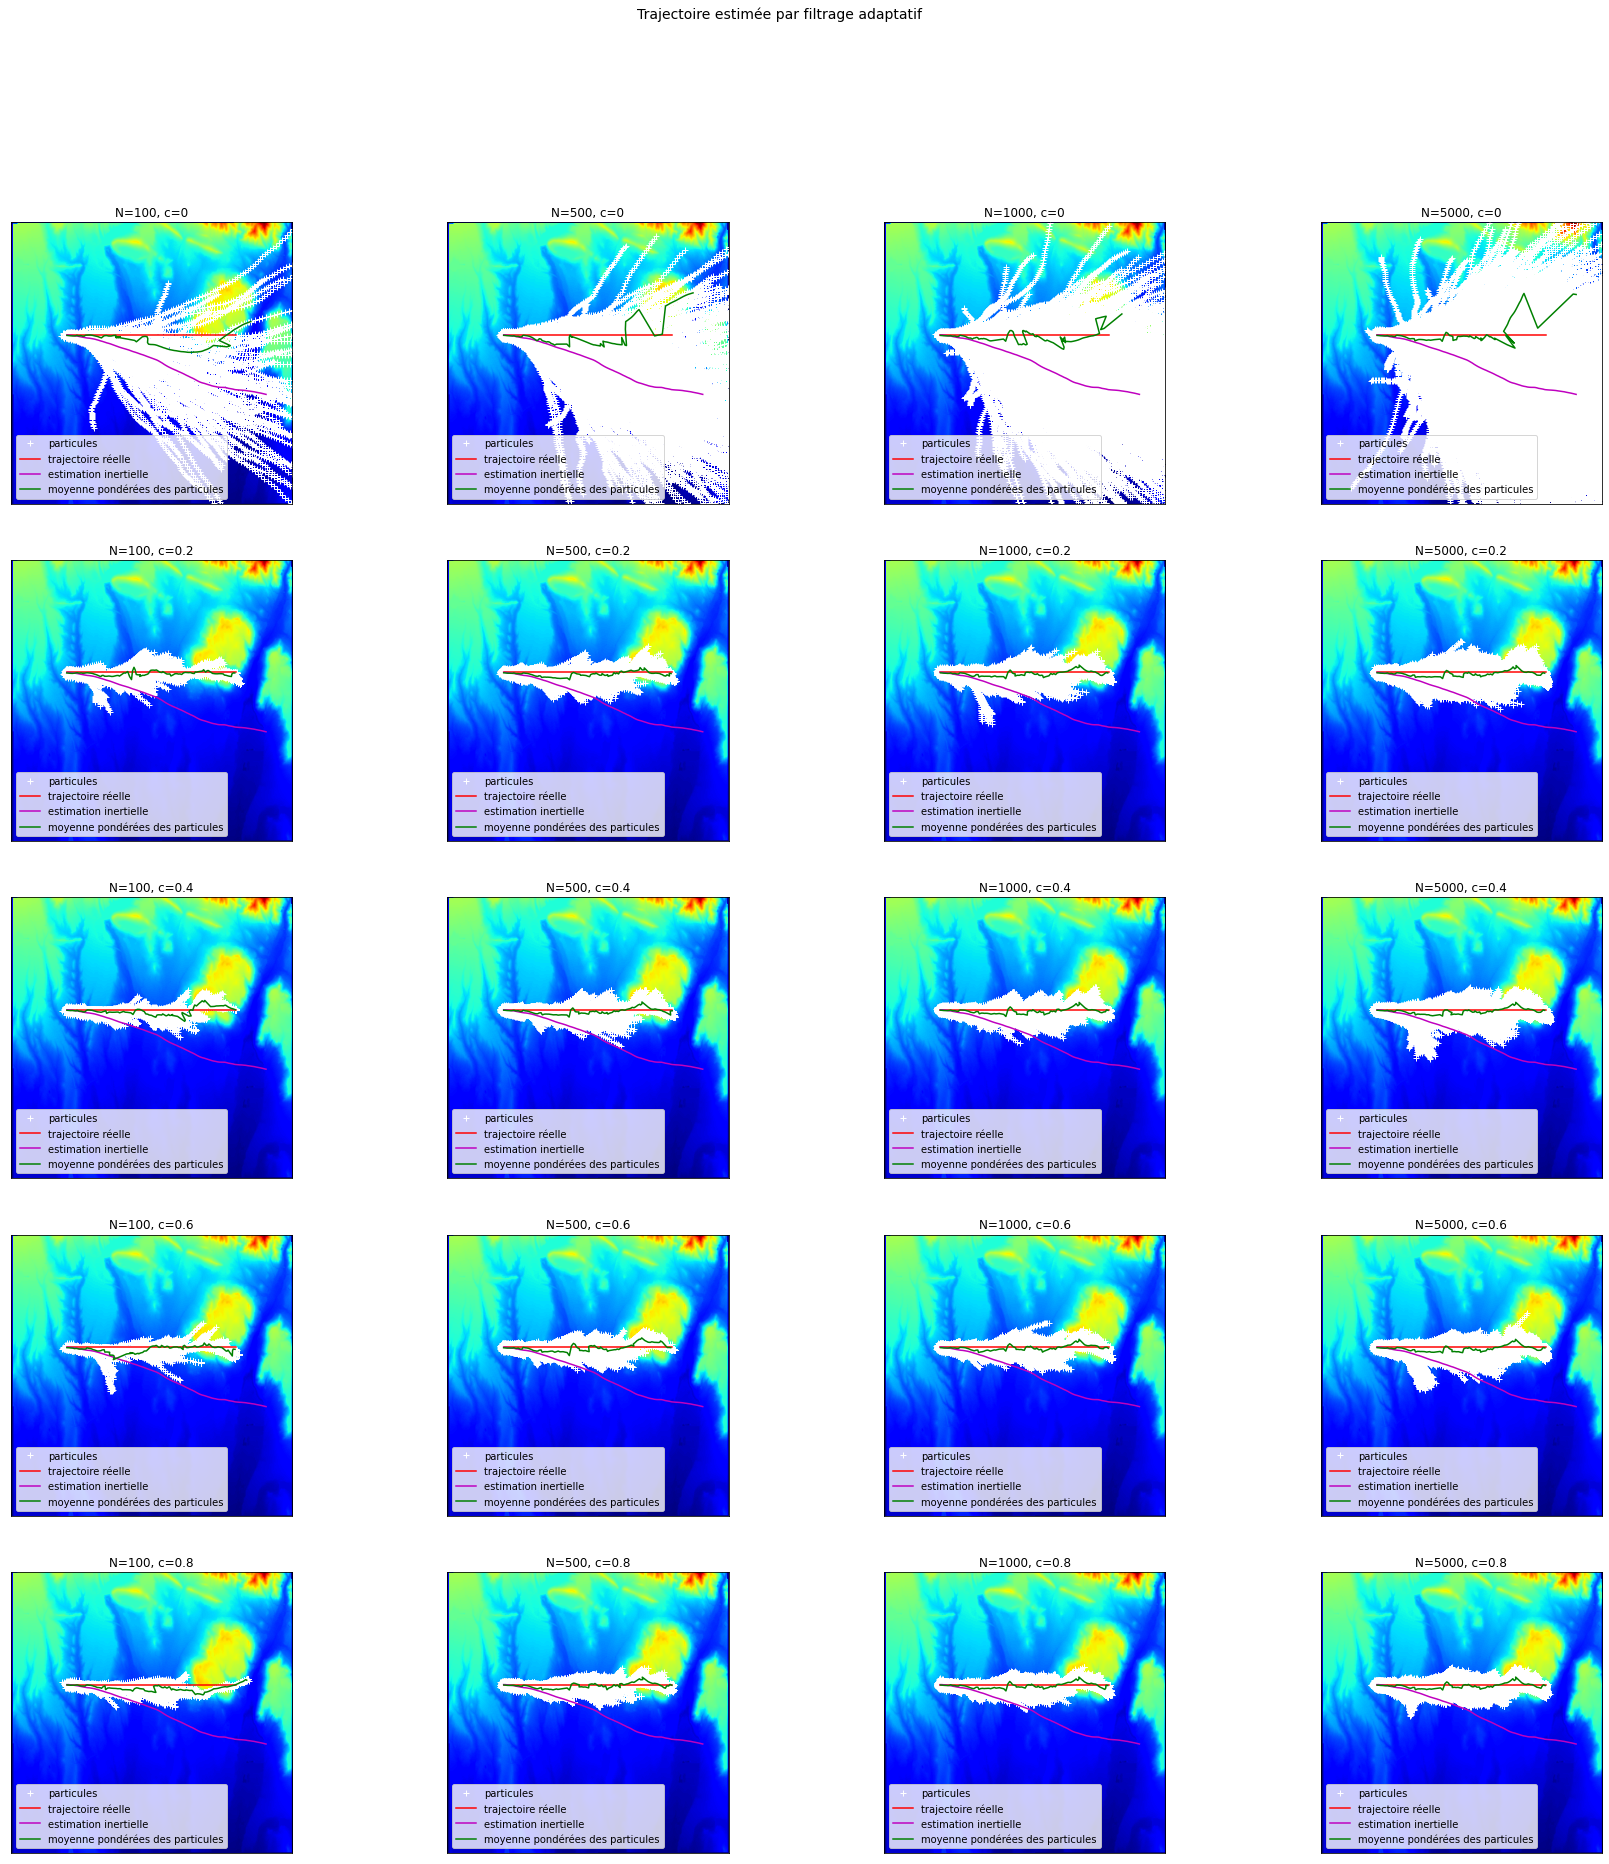

In [47]:
N = [100, 500, 1000, 5000]
c = [0, 0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(30,30))
plt.suptitle("Trajectoire estimée par filtrage adaptatif", fontsize=14)

for idx_n in range(4):
    for idx_c in range(5):

        delta_r,w = adaptative_filter(eta_0, Q, g, N[idx_n], T, c[idx_c])
        r_part = np.zeros((2,N[idx_n],T))
        means = np.zeros((2,T))

        for k in range(T):
            for i in range(N[idx_n]):
                r_part[:,i,k] = r_INS[:,k] + delta_r[k,i,:2] 
                means[:,k] += w[k,i]*r_part[:,i,k] 


        plt.subplot(5,4,idx_n+1 + 4*idx_c)
        plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
        plt.plot(r_part[0,:],r_part[1,:],'+',c='white')
        plt.plot([],[],'+',c='white', label='particules')
        plt.plot(rtrue[0,:],rtrue[1,:],'r-', label='trajectoire réelle')
        plt.plot(r_INS[0,:],r_INS[1,:],'m-', label='estimation inertielle')
        plt.plot(means[0,:], means[1,:], 'green', label='moyenne pondérées des particules')
        plt.xlim(X1MIN,X1MAX)
        plt.ylim(X2MIN,X2MAX)
        plt.title(f"N={N[idx_n]}, c={c[idx_c]}")
        plt.legend(loc='lower left')
        plt.xticks([])
        plt.yticks([])

## 10 - Observations

Le nuage de particules formé par le filtre SIR a une structure plutôt arborescente, dans le sens où certaines particules ayant un score de vraisemblance élevé sont l'origine de plusieurs embranchement. A l'inverse, le nuage de particules du filtre SIS a une structure en étoile, ou toutes les branches proviennent d'une même zone et évoluent indépendamment les unes des autres, le nuage est donc beaucoup plus étendu que pour le SIR.

On constate que la trajectoire estimée par le SIR est plus proche de la trajectoire réelle que celle du SIS pour un même nombre de particules par pas de temps, mais le SIS semble plus adapté pour l'exploration : si l'estimation de base est très mauvaise car les senseurs ont beaucoup de bruit, ou si le relief comporte des discontinuités, alors les particules du SIS vont aller "chercher plus loin" et aura plus de chance d'avoir des particules vraisemblables de part l'étendue de son nuage.

Le filtre adaptatif permet de combiner les deux avantages : si le nuage de particule créé par le SIR à un temps $k$ n'est pas assez performant (i.e. les particules ont toutes des vraisemblances proches), on bascule sur un SIS pour "explorer" un peu plus loin. Dans notre cas, sans toutefois qu'aucune étude plus aprofondie n'ait été faite, le filtre semble fonctionner au mieux pour $c = 0.8$ .

L'augmentation du nombre de particules permet d'augmenter la densité et l'étendue du nuage de particule, améliorant la précision de l'estimation.

Le point négatif de ces différentes méthodes de filtrages est que la trajectoire retenue, tracée en vert sur les graphes, ne suit pas les lois de la dynamique décrites par la fonction $Q$, et par conséquent ne peuventpas représenter une trajectoire réelle, c'est pourquoi pour pouvoir exploiter au mieux les résultats obtenus il faudrait lisser a posteriori la trajectoire obtenue afin qu'elle ait un sens physique et non seulement mathématique.